### Importing Necessary Libraries

In [46]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [47]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [48]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [49]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [50]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [51]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [52]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

In [53]:
fine_tune_data = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 1536)

In [54]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [55]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 1536)

In [56]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [57]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 1536)

In [58]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

In [59]:
N_COMPS = 840
pcas = [PCA(N_COMPS) for _ in range(5)]

In [60]:
for i in range(5):
    pcas[i].fit(fine_tune_data_train[:,i,:])

In [61]:
fine_tune_data_train_red = np.zeros((fine_tune_data_train.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_train_red[:,i,:] = pcas[i].transform(fine_tune_data_train[:,i,:])

In [62]:
fine_tune_data_train_red.shape

(15200, 5, 840)

In [63]:
fine_tune_data_test_red = np.zeros((fine_tune_data_test.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_test_red[:,i,:] = pcas[i].transform(fine_tune_data_test[:,i,:])

In [64]:
fine_tune_data_test_red.shape

(800, 5, 840)

## Fine-Tuning Models

The fine-tuning part of our model.

In [65]:
def ftmodel():
    inputs = Input(shape=(5, N_COMPS))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='Inception-ResNet-FineTune')
    return model1

In [66]:
model1 = ftmodel()
model1.summary()

Model: "Inception-ResNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 840)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 4200)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 4200)             16800     
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 4200)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               2150912   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                         

### Model Training

The fine-tuning will be done on the Inception-ResNet's $1536D$ representation vectors.

In [67]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [68]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/Inception-ResNet-4P-PCA/auto-Inception-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [69]:
history = model1.fit(fine_tune_data_train_red, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test_red, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/Inception-ResNet-4P-PCA/resnet-4p-model-weights")
model1.load_weights('./Models/Inception-ResNet-4P-PCA/resnet-4p-model-weights')

Epoch 1/1000


2022-10-08 19:13:34.016500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 50ms/step - loss: 3.7089 - accuracy: 0.1201 - val_loss: 2.2748 - val_accuracy: 0.4725
Epoch 2/1000
 1/19 [>.............................] - ETA: 0s - loss: 2.9189 - accuracy: 0.2425

2022-10-08 19:13:35.214834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 25ms/step - loss: 2.6680 - accuracy: 0.3036 - val_loss: 1.9582 - val_accuracy: 0.5450
Epoch 3/1000
19/19 [==============================] - 0s 14ms/step - loss: 2.0875 - accuracy: 0.4376 - val_loss: 1.7752 - val_accuracy: 0.5750
Epoch 4/1000
19/19 [==============================] - 0s 14ms/step - loss: 1.7277 - accuracy: 0.5288 - val_loss: 1.6584 - val_accuracy: 0.5888
Epoch 5/1000
19/19 [==============================] - 0s 14ms/step - loss: 1.4988 - accuracy: 0.5874 - val_loss: 1.5730 - val_accuracy: 0.6075
Epoch 6/1000
19/19 [==============================] - 0s 15ms/step - loss: 1.3450 - accuracy: 0.6269 - val_loss: 1.5067 - val_accuracy: 0.6237
Epoch 7/1000
19/19 [==============================] - 0s 15ms/step - loss: 1.2324 - accuracy: 0.6575 - val_loss: 1.4493 - val_accuracy: 0.6375
Epoch 8/1000
19/19 [==============================] - 0s 15ms/step - loss: 1.1376 - accuracy: 0.6850 - val_loss: 1.3986 - val_accuracy: 0.6475
Epoch 9/1000

19/19 [==============================] - 0s 15ms/step - loss: 0.3092 - accuracy: 0.9189 - val_loss: 0.8812 - val_accuracy: 0.7962
Epoch 60/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.2987 - accuracy: 0.9241 - val_loss: 0.8809 - val_accuracy: 0.7937
Epoch 61/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.2980 - accuracy: 0.9232 - val_loss: 0.8818 - val_accuracy: 0.7912
Epoch 62/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.2979 - accuracy: 0.9225 - val_loss: 0.8807 - val_accuracy: 0.7862
Epoch 63/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.2939 - accuracy: 0.9264 - val_loss: 0.8822 - val_accuracy: 0.7850
Epoch 64/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.2854 - accuracy: 0.9269 - val_loss: 0.8813 - val_accuracy: 0.7887
Epoch 65/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.2895 - accuracy: 0.9263 - val_loss: 0.8806 - val_accuracy: 0.7887
Epoch 

Epoch 116/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1855 - accuracy: 0.9603 - val_loss: 0.9140 - val_accuracy: 0.7950
Epoch 117/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1737 - accuracy: 0.9661 - val_loss: 0.9128 - val_accuracy: 0.7937
Epoch 118/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1740 - accuracy: 0.9656 - val_loss: 0.9158 - val_accuracy: 0.7962
Epoch 119/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1749 - accuracy: 0.9659 - val_loss: 0.9149 - val_accuracy: 0.8000
Epoch 120/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1743 - accuracy: 0.9662 - val_loss: 0.9151 - val_accuracy: 0.7987
Epoch 121/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.1696 - accuracy: 0.9678 - val_loss: 0.9128 - val_accuracy: 0.7925
Epoch 122/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1714 - accuracy: 0.9667 - val_loss: 0.9175 - val_ac

19/19 [==============================] - 0s 11ms/step - loss: 0.1314 - accuracy: 0.9809 - val_loss: 0.9302 - val_accuracy: 0.7887
Epoch 173/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.1255 - accuracy: 0.9807 - val_loss: 0.9340 - val_accuracy: 0.7900
Epoch 174/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1309 - accuracy: 0.9803 - val_loss: 0.9335 - val_accuracy: 0.7925
Epoch 175/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1340 - accuracy: 0.9793 - val_loss: 0.9366 - val_accuracy: 0.7950
Epoch 176/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1294 - accuracy: 0.9807 - val_loss: 0.9379 - val_accuracy: 0.7900
Epoch 177/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1265 - accuracy: 0.9820 - val_loss: 0.9390 - val_accuracy: 0.7887
Epoch 178/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1300 - accuracy: 0.9801 - val_loss: 0.9409 - val_accuracy: 0.7925


19/19 [==============================] - 0s 15ms/step - loss: 0.1097 - accuracy: 0.9856 - val_loss: 0.9341 - val_accuracy: 0.7962
Epoch 229/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1139 - accuracy: 0.9857 - val_loss: 0.9336 - val_accuracy: 0.8025
Epoch 230/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1131 - accuracy: 0.9854 - val_loss: 0.9381 - val_accuracy: 0.7925
Epoch 231/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1126 - accuracy: 0.9865 - val_loss: 0.9429 - val_accuracy: 0.7925
Epoch 232/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1114 - accuracy: 0.9857 - val_loss: 0.9420 - val_accuracy: 0.7937
Epoch 233/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1142 - accuracy: 0.9856 - val_loss: 0.9472 - val_accuracy: 0.7925
Epoch 234/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1161 - accuracy: 0.9852 - val_loss: 0.9465 - val_accuracy: 0.7912


19/19 [==============================] - 0s 10ms/step - loss: 0.1063 - accuracy: 0.9891 - val_loss: 0.9738 - val_accuracy: 0.7900
Epoch 285/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1111 - accuracy: 0.9869 - val_loss: 0.9684 - val_accuracy: 0.7912
Epoch 286/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1076 - accuracy: 0.9880 - val_loss: 0.9641 - val_accuracy: 0.7900
Epoch 287/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1090 - accuracy: 0.9882 - val_loss: 0.9651 - val_accuracy: 0.7925
Epoch 288/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1072 - accuracy: 0.9886 - val_loss: 0.9651 - val_accuracy: 0.7875
Epoch 289/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1072 - accuracy: 0.9880 - val_loss: 0.9676 - val_accuracy: 0.7912
Epoch 290/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1082 - accuracy: 0.9882 - val_loss: 0.9644 - val_accuracy: 0.7912


19/19 [==============================] - 0s 10ms/step - loss: 0.1040 - accuracy: 0.9886 - val_loss: 0.9604 - val_accuracy: 0.7925
Epoch 341/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1000 - accuracy: 0.9907 - val_loss: 0.9619 - val_accuracy: 0.7887
Epoch 342/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0985 - accuracy: 0.9908 - val_loss: 0.9630 - val_accuracy: 0.7900
Epoch 343/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1009 - accuracy: 0.9909 - val_loss: 0.9681 - val_accuracy: 0.7937
Epoch 344/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0997 - accuracy: 0.9915 - val_loss: 0.9691 - val_accuracy: 0.7887
Epoch 345/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1025 - accuracy: 0.9903 - val_loss: 0.9787 - val_accuracy: 0.7875
Epoch 346/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0995 - accuracy: 0.9915 - val_loss: 0.9741 - val_accuracy: 0.7837


19/19 [==============================] - 0s 11ms/step - loss: 0.1054 - accuracy: 0.9899 - val_loss: 0.9898 - val_accuracy: 0.7950
Epoch 397/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1010 - accuracy: 0.9911 - val_loss: 0.9941 - val_accuracy: 0.7912
Epoch 398/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1020 - accuracy: 0.9909 - val_loss: 0.9951 - val_accuracy: 0.7887
Epoch 399/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0997 - accuracy: 0.9914 - val_loss: 0.9904 - val_accuracy: 0.7900
Epoch 400/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1028 - accuracy: 0.9901 - val_loss: 0.9844 - val_accuracy: 0.7900
Epoch 401/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0993 - accuracy: 0.9910 - val_loss: 0.9838 - val_accuracy: 0.7925
Epoch 402/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1004 - accuracy: 0.9911 - val_loss: 0.9835 - val_accuracy: 0.7937


19/19 [==============================] - 0s 11ms/step - loss: 0.1000 - accuracy: 0.9909 - val_loss: 0.9862 - val_accuracy: 0.7962
Epoch 453/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0969 - accuracy: 0.9926 - val_loss: 0.9835 - val_accuracy: 0.7975
Epoch 454/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0979 - accuracy: 0.9920 - val_loss: 0.9789 - val_accuracy: 0.7950
Epoch 455/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0999 - accuracy: 0.9922 - val_loss: 0.9832 - val_accuracy: 0.8000
Epoch 456/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1005 - accuracy: 0.9907 - val_loss: 0.9890 - val_accuracy: 0.7962
Epoch 457/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0970 - accuracy: 0.9924 - val_loss: 0.9905 - val_accuracy: 0.7975
Epoch 458/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0997 - accuracy: 0.9911 - val_loss: 0.9903 - val_accuracy: 0.7950


19/19 [==============================] - 0s 10ms/step - loss: 0.1011 - accuracy: 0.9911 - val_loss: 0.9934 - val_accuracy: 0.7950
Epoch 509/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1016 - accuracy: 0.9911 - val_loss: 0.9989 - val_accuracy: 0.7937
Epoch 510/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0990 - accuracy: 0.9917 - val_loss: 1.0033 - val_accuracy: 0.7925
Epoch 511/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0954 - accuracy: 0.9930 - val_loss: 1.0018 - val_accuracy: 0.7900
Epoch 512/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0981 - accuracy: 0.9926 - val_loss: 0.9978 - val_accuracy: 0.7950
Epoch 513/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0975 - accuracy: 0.9924 - val_loss: 0.9965 - val_accuracy: 0.7962
Epoch 514/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1005 - accuracy: 0.9912 - val_loss: 1.0007 - val_accuracy: 0.7962


19/19 [==============================] - 0s 10ms/step - loss: 0.1023 - accuracy: 0.9906 - val_loss: 0.9817 - val_accuracy: 0.8012
Epoch 565/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0964 - accuracy: 0.9926 - val_loss: 0.9848 - val_accuracy: 0.8050
Epoch 566/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1005 - accuracy: 0.9921 - val_loss: 0.9917 - val_accuracy: 0.8025
Epoch 567/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1018 - accuracy: 0.9909 - val_loss: 0.9967 - val_accuracy: 0.8000
Epoch 568/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0970 - accuracy: 0.9932 - val_loss: 0.9964 - val_accuracy: 0.7987
Epoch 569/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0990 - accuracy: 0.9922 - val_loss: 0.9935 - val_accuracy: 0.7925
Epoch 570/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1006 - accuracy: 0.9922 - val_loss: 0.9933 - val_accuracy: 0.7975


19/19 [==============================] - 0s 10ms/step - loss: 0.1001 - accuracy: 0.9926 - val_loss: 0.9922 - val_accuracy: 0.7937
Epoch 621/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0976 - accuracy: 0.9924 - val_loss: 0.9984 - val_accuracy: 0.7900
Epoch 622/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0995 - accuracy: 0.9922 - val_loss: 1.0044 - val_accuracy: 0.7937
Epoch 623/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0961 - accuracy: 0.9933 - val_loss: 1.0066 - val_accuracy: 0.7912
Epoch 624/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0991 - accuracy: 0.9929 - val_loss: 1.0056 - val_accuracy: 0.7925
Epoch 625/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0998 - accuracy: 0.9928 - val_loss: 1.0046 - val_accuracy: 0.7937
Epoch 626/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0984 - accuracy: 0.9930 - val_loss: 1.0032 - val_accuracy: 0.7925


19/19 [==============================] - 0s 11ms/step - loss: 0.1001 - accuracy: 0.9922 - val_loss: 1.0189 - val_accuracy: 0.7887
Epoch 677/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1009 - accuracy: 0.9923 - val_loss: 1.0160 - val_accuracy: 0.7912
Epoch 678/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0969 - accuracy: 0.9932 - val_loss: 1.0118 - val_accuracy: 0.7950
Epoch 679/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0996 - accuracy: 0.9923 - val_loss: 1.0121 - val_accuracy: 0.7925
Epoch 680/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1026 - accuracy: 0.9922 - val_loss: 1.0087 - val_accuracy: 0.7950
Epoch 681/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0987 - accuracy: 0.9927 - val_loss: 1.0044 - val_accuracy: 0.7962
Epoch 682/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0975 - accuracy: 0.9930 - val_loss: 1.0064 - val_accuracy: 0.7975


19/19 [==============================] - 0s 10ms/step - loss: 0.0989 - accuracy: 0.9927 - val_loss: 1.0286 - val_accuracy: 0.7937
Epoch 733/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0959 - accuracy: 0.9934 - val_loss: 1.0218 - val_accuracy: 0.7937
Epoch 734/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0993 - accuracy: 0.9928 - val_loss: 1.0216 - val_accuracy: 0.7912
Epoch 735/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0987 - accuracy: 0.9930 - val_loss: 1.0263 - val_accuracy: 0.7912
Epoch 736/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0956 - accuracy: 0.9941 - val_loss: 1.0317 - val_accuracy: 0.7950
Epoch 737/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0970 - accuracy: 0.9936 - val_loss: 1.0315 - val_accuracy: 0.7962
Epoch 738/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0982 - accuracy: 0.9931 - val_loss: 1.0283 - val_accuracy: 0.8000


19/19 [==============================] - 0s 10ms/step - loss: 0.0986 - accuracy: 0.9936 - val_loss: 1.0493 - val_accuracy: 0.7875
Epoch 789/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0973 - accuracy: 0.9935 - val_loss: 1.0461 - val_accuracy: 0.7862
Epoch 790/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1002 - accuracy: 0.9920 - val_loss: 1.0451 - val_accuracy: 0.7837
Epoch 791/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0947 - accuracy: 0.9948 - val_loss: 1.0419 - val_accuracy: 0.7850
Epoch 792/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.1025 - accuracy: 0.9929 - val_loss: 1.0370 - val_accuracy: 0.7862
Epoch 793/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0992 - accuracy: 0.9927 - val_loss: 1.0379 - val_accuracy: 0.7825
Epoch 794/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0984 - accuracy: 0.9926 - val_loss: 1.0378 - val_accuracy: 0.7875


19/19 [==============================] - 0s 10ms/step - loss: 0.0996 - accuracy: 0.9929 - val_loss: 1.0615 - val_accuracy: 0.7987
Epoch 845/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0966 - accuracy: 0.9938 - val_loss: 1.0642 - val_accuracy: 0.8012
Epoch 846/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0997 - accuracy: 0.9932 - val_loss: 1.0637 - val_accuracy: 0.7987
Epoch 847/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0958 - accuracy: 0.9942 - val_loss: 1.0628 - val_accuracy: 0.7937
Epoch 848/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0966 - accuracy: 0.9935 - val_loss: 1.0639 - val_accuracy: 0.7950
Epoch 849/1000
19/19 [==============================] - 0s 10ms/step - loss: 0.0989 - accuracy: 0.9926 - val_loss: 1.0616 - val_accuracy: 0.7950
Epoch 850/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0987 - accuracy: 0.9929 - val_loss: 1.0625 - val_accuracy: 0.7950


19/19 [==============================] - 0s 11ms/step - loss: 0.0973 - accuracy: 0.9929 - val_loss: 1.0810 - val_accuracy: 0.7937
Epoch 901/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0998 - accuracy: 0.9928 - val_loss: 1.0809 - val_accuracy: 0.7925
Epoch 902/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0991 - accuracy: 0.9925 - val_loss: 1.0803 - val_accuracy: 0.7912
Epoch 903/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0981 - accuracy: 0.9938 - val_loss: 1.0821 - val_accuracy: 0.7950
Epoch 904/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0987 - accuracy: 0.9924 - val_loss: 1.0859 - val_accuracy: 0.7937
Epoch 905/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0988 - accuracy: 0.9935 - val_loss: 1.0875 - val_accuracy: 0.7937
Epoch 906/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0974 - accuracy: 0.9941 - val_loss: 1.0848 - val_accuracy: 0.7925


19/19 [==============================] - 0s 11ms/step - loss: 0.0954 - accuracy: 0.9941 - val_loss: 1.0782 - val_accuracy: 0.7937
Epoch 957/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0989 - accuracy: 0.9938 - val_loss: 1.0847 - val_accuracy: 0.7937
Epoch 958/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.1004 - accuracy: 0.9932 - val_loss: 1.0881 - val_accuracy: 0.7912
Epoch 959/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0976 - accuracy: 0.9926 - val_loss: 1.0972 - val_accuracy: 0.7900
Epoch 960/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0968 - accuracy: 0.9939 - val_loss: 1.1073 - val_accuracy: 0.7950
Epoch 961/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0975 - accuracy: 0.9936 - val_loss: 1.1014 - val_accuracy: 0.7962
Epoch 962/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.0946 - accuracy: 0.9945 - val_loss: 1.0927 - val_accuracy: 0.7987


In [94]:
model1.load_weights('./Models/Inception-ResNet-4P-PCA/auto-Inception-ResNet-FT-model-weight')

In [95]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

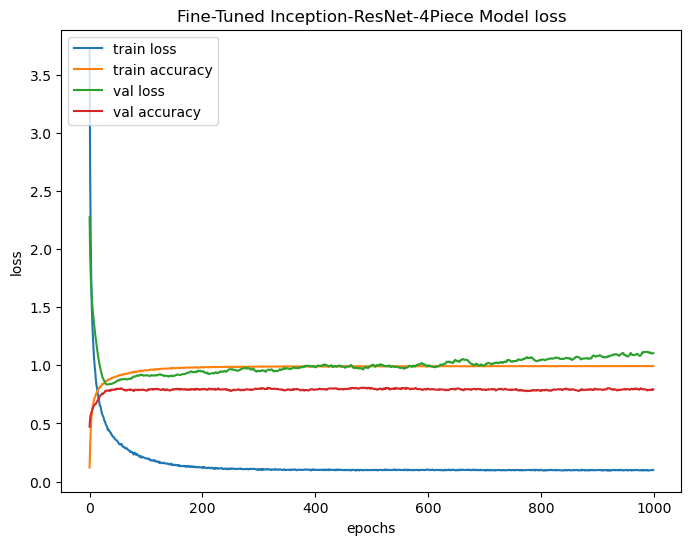

In [96]:
plot_train_loss(history, 'Fine-Tuned Inception-ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [97]:
train_preds = model1.predict(fine_tune_data_train_red)

475/475 [==============================] - 1s 2ms/step


In [98]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [99]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [100]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [101]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [102]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.997959,1.000000,0.998979,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [103]:
test_preds = model1.predict(fine_tune_data_test_red)

25/25 [==============================] - 0s 3ms/step


In [104]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [105]:
test_pred_labels

array([11,  8,  0,  7, 10,  6, 13, 12, 14,  1,  6,  0,  7, 14, 13, 11,  0,
        9,  6, 12,  8, 14,  3, 12,  6,  0,  3, 14,  3,  3, 10,  1,  9,  2,
        6,  8,  4, 13, 11,  9,  6, 12, 14,  2,  5, 14,  5,  0, 13,  4,  0,
       10, 12,  0, 11, 14, 15,  9,  9,  2, 15, 13, 11, 11,  6, 10,  8,  0,
        6,  3,  4,  4, 12,  5,  8,  6,  7,  0, 12, 11, 11, 15, 12, 12,  9,
        8, 13, 13, 13, 13, 10, 11,  4, 10,  1, 10, 11,  8, 13, 10,  3, 11,
       12,  9,  7, 14,  8,  2,  5, 15,  7, 13,  9,  4, 12, 12, 12, 13, 11,
        6, 13,  1,  0, 12,  1,  5, 10, 12, 15, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8,  5,  8,  9,  2, 13,  0,  5,  4,
       14,  4,  9,  9, 14,  7,  7,  8,  4,  9,  5, 13,  8,  2,  8,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 13, 10, 11, 11, 10,  1,  9,  1,
        9,  5, 13, 14, 12,  1,  4,  8,  7,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  1,  7,  7

In [106]:
np.sum(test_pred_labels == test_labels['label'])

635

In [107]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
...,...,...,...
782,15582,./Data/train/train/15582.tif,3
783,15589,./Data/train/train/15589.tif,5
784,15596,./Data/train/train/15596.tif,8
788,15687,./Data/train/train/15687.tif,12


In [108]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.706897,0.759259,0.732143,54
1,0.674419,0.659091,0.666667,44
2,0.906977,0.906977,0.906977,43
3,0.933333,0.913043,0.923077,46
4,0.925926,0.694444,0.793651,36
5,0.820513,0.640000,0.719101,50
6,0.847826,0.847826,0.847826,46
7,0.857143,0.807692,0.831683,52
8,0.868852,0.981481,0.921739,54
9,0.770833,0.787234,0.778947,47


In [109]:
np.mean(fscore)

0.7927985931890755

#### On Validation Data

Generating Predictions for the Validation Set

In [110]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [111]:
fine_tune_data_validation = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')

In [112]:
fine_tune_data_validation.shape

(900, 5, 1536)

In [113]:
fine_tune_data_validation_red = np.zeros((fine_tune_data_validation.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_validation_red[:,i,:] = pcas[i].transform(fine_tune_data_validation[:,i,:])

In [114]:
valid_preds = model1.predict(fine_tune_data_validation_red)

29/29 [==============================] - 0s 3ms/step


In [115]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [116]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,9
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,3


In [117]:
submission_data.to_csv('./Submissions/submission-inception-resnet-4p-PCA.csv', index=False)